<a href="https://colab.research.google.com/github/fan-of-dark/UNET_Segmentation/blob/main/Brain_Tumor_Preprocessing_15-09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/ECE_MINI_PROJECT/Brain_Tumor/data/"
img_path = "/content/drive/MyDrive/ECE_MINI_PROJECT/Brain_Tumor/data/imgs/"
mask_path = "/content/drive/MyDrive/ECE_MINI_PROJECT/Brain_Tumor/data/masks/"

Importing Libraries

In [5]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")
from skimage.io import imread, imshow
import imutils
import cv2 as cv

Img and Mask Generators 

In [6]:
imgs = next(os.walk(img_path))[2]
masks = next(os.walk(mask_path))[2]

In [9]:
len(imgs)

3929

In [10]:
#img index 
index = 333

In [11]:
img = imread(img_path+imgs[index])
mask = imread(mask_path+masks[index])

Function to display multiple pics

In [40]:
def show(*args):
  fig = plt.figure(figsize= (12,8))
  if len(args) == 1:
      imshow(args[0])
      plt.axis("off")
  else:    
      rows,cols = np.ceil(np.sqrt(len(args))), np.ceil(np.sqrt(len(args)))
      if len(args)%2 == 1:
          args = list(args)
          args.append(args[0])
      if len(args) == 2:
          rows = 1
          cols = 2
      i = 1
      while i <= rows*cols:
          if i > len(args): break
          fig.add_subplot(rows,cols,i)
          imshow(args[min(i-1,len(args)-1)])
          plt.axis("off")
          i += 1
  plt.show()

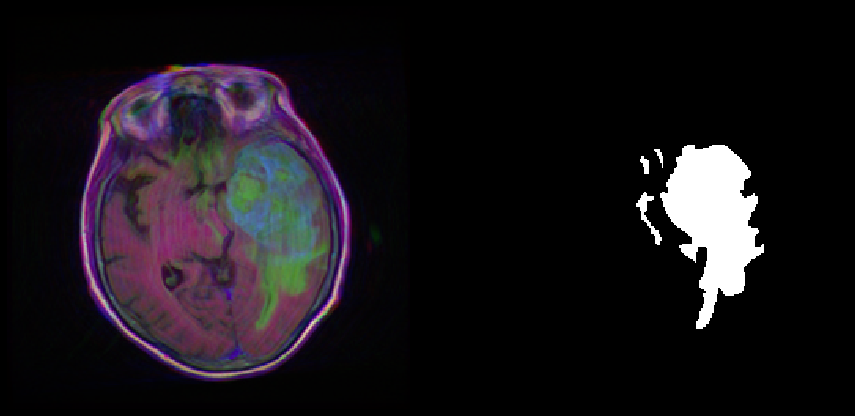

In [41]:
show(img, mask)

De-Noising

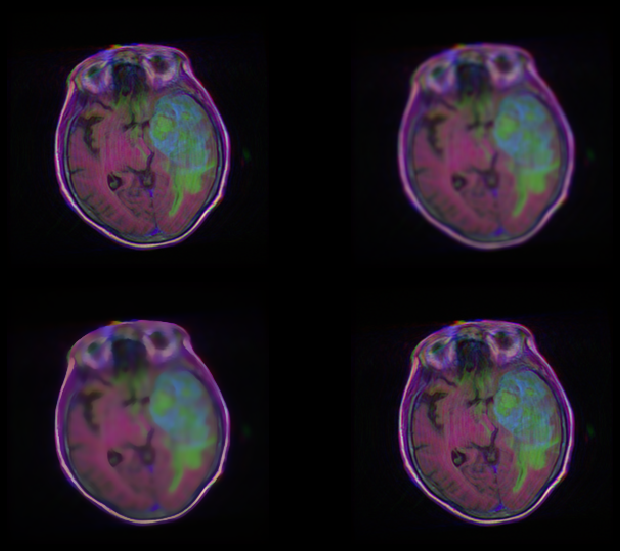

In [54]:
#guassian or normal blurring
blur1 = cv.GaussianBlur(img,(5,5), cv.BORDER_DEFAULT)

#bilateral filter
# A nice trick to smooth out the image without blurring the edges is called bilateral filtering.
blur2 = cv.bilateralFilter(img,d = 9,sigmaColor = 75 ,sigmaSpace = 75) 

show(img, blur1, blur2)

bilateral is better

In [55]:
def make_blur(img):
  return cv.bilateralFilter(img,d = 9,sigmaColor = 75 ,sigmaSpace = 75)

Gray Level Enhancement

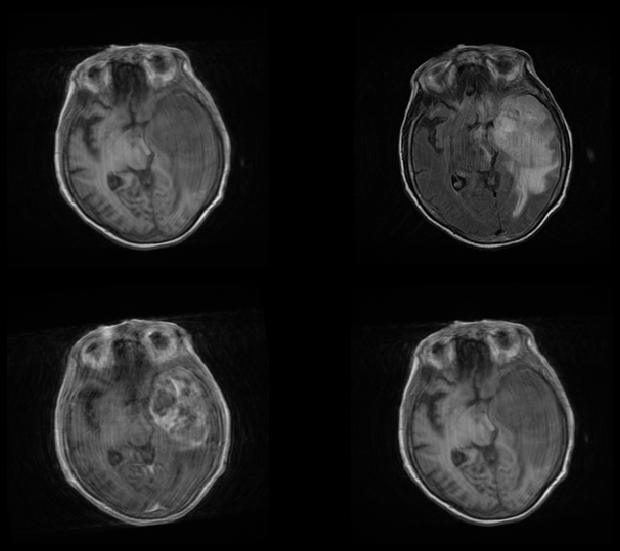

In [42]:
red = img[:,:,0]
green = img[:,:,1]
blue = img[:,:,2]

show(red, green, blue)

WE can observe that green is better

previous dry run also confirmed that model overfitting to green
lets try weighted gray level 

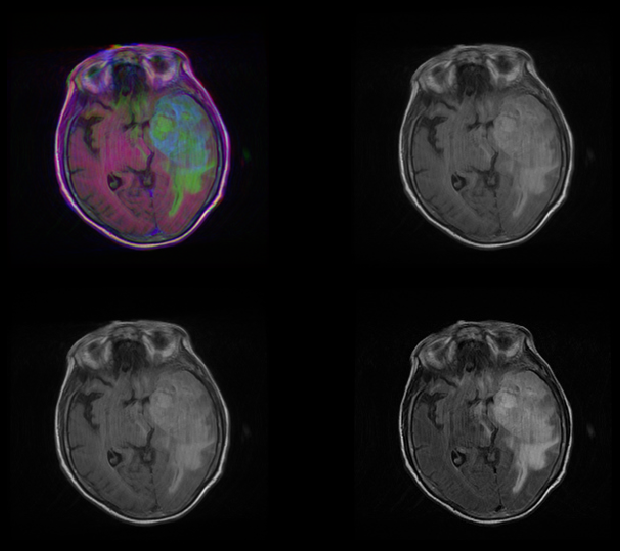

In [45]:
gray1 = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

gray2 = 0.3*red + 0.6*green + 0.1*blue
gray2 = gray2.astype(np.uint8)

show(img, gray1, gray2, green)

We can try only green or gray2

In [67]:
def to_gray(img):
  red = img[:,:,0]
  green = img[:,:,1]
  blue = img[:,:,2]

  gray = 0.3*red + 0.6*green + 0.1*blue
  gray = gray.astype(np.uint8)
  return gray

lets try with histogram for contrast adjustment

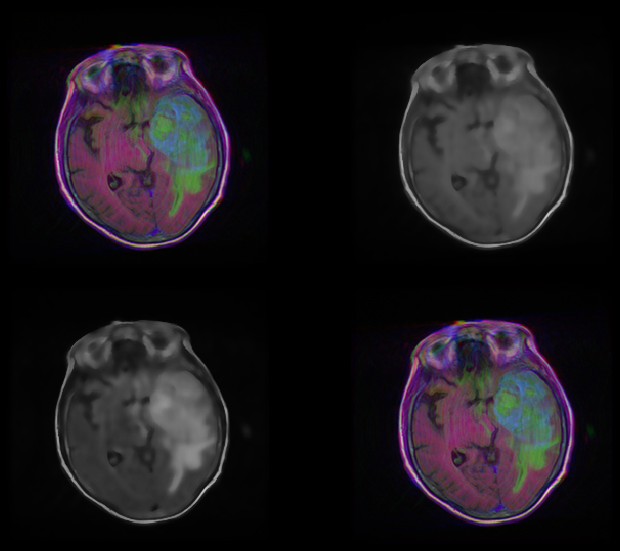

In [58]:
gray,green = to_gray(make_blur(img))
show(img, gray, green)

In [77]:
nhe = cv.equalizeHist(to_gray(img))

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import imageio
import scipy, scipy.misc, scipy.signal
import cv2
import sys

def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei+4, wid+4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = hsv[:,:,1] * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T
    
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]
    
    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2+dSv**2).astype(np.uint32)
    ds = dS[2:hei+2,2:wid+2]

    
    h = H[2:hei+2,2:wid+2]
    s = S[2:hei+2,2:wid+2]
    i = I[2:hei+2,2:wid+2].astype(np.uint8)
    
    Imean = scipy.signal.convolve2d(I,np.ones((5,5))/25, mode='same')
    Smean = scipy.signal.convolve2d(S,np.ones((5,5))/25, mode='same')
    
    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]
    
    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))
    
    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S

def dhe(img, alpha=0.5):
    
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)
    
    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)
    
    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)
    
    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


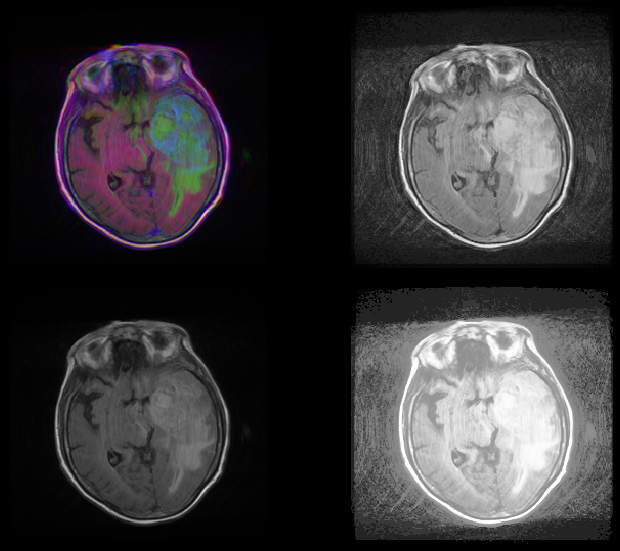

In [79]:
dhe_ = dhe(img)
a = to_gray(dhe_)
b = to_gray(img)
show(img, a, b, nhe)

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import imageio
import scipy, scipy.misc, scipy.signal
import cv2
import sys

import warnings
warnings.filterwarnings("ignore", category= RuntimeWarning)

def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei+4, wid+4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = hsv[:,:,1] * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T
    
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]
    
    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2+dSv**2).astype(np.uint32)
    ds = dS[2:hei+2,2:wid+2]

    
    h = H[2:hei+2,2:wid+2]
    s = S[2:hei+2,2:wid+2]
    i = I[2:hei+2,2:wid+2].astype(np.uint8)
    
    Imean = scipy.signal.convolve2d(I,np.ones((5,5))/25, mode='same')
    Smean = scipy.signal.convolve2d(S,np.ones((5,5))/25, mode='same')
    
    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]
    
    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))
    
    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S

def dhe(img, alpha=0.5):
    
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)
    
    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)
    
    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)
    
    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

def preprocess(img):
  dhe_ = dhe(img)
  a = to_gray(dhe_)
  return a

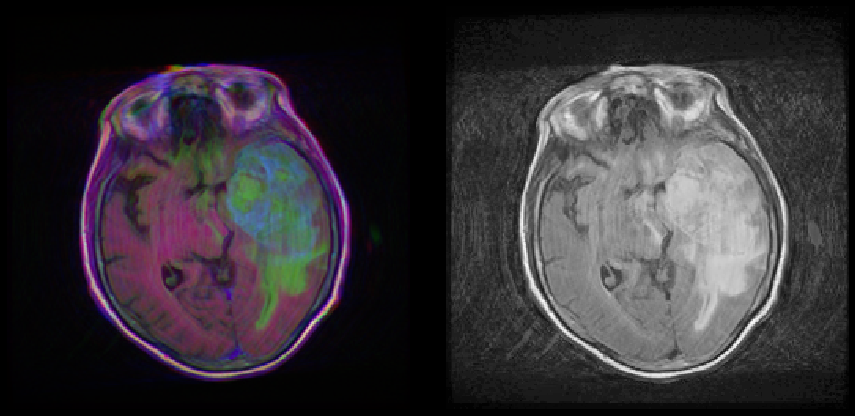

In [88]:
show(img,preprocess(img))